In [1]:
from wann_genetic.tools import ExperimentSeries
from util import accuracy_swarmplot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from wann_genetic.individual.torch import Individual

In [2]:
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

In [3]:
data_dir = "../data/03_iris_edge_mutation/"
series = ExperimentSeries.from_spec_file(data_dir)
series.discover_data_dir()
df = series.assemble_stats()
x_col = 'mutation_type'
x_label = 'Edge introduction strategy'
df[x_col] = df[x_col].map({
    'layer_based': 'Layer based',
    'layer_agnostic': 'Layer agnostic'})

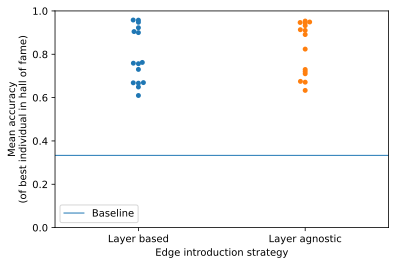

In [4]:
accuracy_swarmplot(data=df, x=x_col, xlabel=x_label, old_metrics=True)

In [5]:
a = df[df['mutation_type'] == 'Layer agnostic']['mean accuracy']
b = df[df['mutation_type'] == 'Layer based']['mean accuracy']
print(f'mean with layer agnostic approach: {a.mean()}, with layer based approach: {b.mean()}')
from scipy.stats import ttest_ind
t, p = ttest_ind(a, b, equal_var=False)
print (t, p)

mean with layer agnostic approach: 0.8269555555555556, with layer based approach: 0.7907955555555558
0.7940849199030393 0.4338381754475754


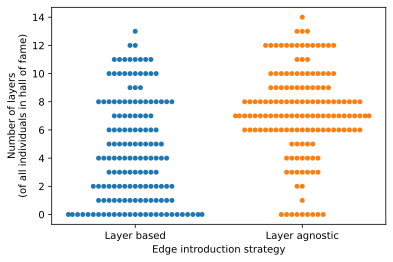

In [6]:
layer_data = list()

for _, row in df.iterrows():
    env = series.configuration_env(row['_configuration'])
    
    env.ind_class.Genotype.edge_encoding = (
        # innovation number
        ('id', np.dtype(int)),

         # id of source node (any but output)
        ('src', np.dtype(int)),

        # id of destination node (either hidden or output)
        ('dest', np.dtype(int)),

        # sign needs to be retained even if disabled, in case the edge is
        # reenabled
        ('enabled', np.dtype(bool))
    )
    
    with env.open_data():
        env.load_hof()
    
    for ind in env.hall_of_fame:
        ind.express()
        
        d = ind.metadata()
        layer_data.append({
            'n_layers': d['n_layers'],
            'mutation_type': row['mutation_type']
            
        })

layer_df = pd.DataFrame(layer_data)

sns.swarmplot(x='mutation_type', y='n_layers', data=layer_df)
plt.xlabel(x_label)
plt.ylabel('Number of layers\n(of all individuals in hall of fame)')
plt.show()

In [7]:
print(series.hyperparam_table(tablefmt='grid'))

+----------------------------------------------------+--------------------------------------+
| Parameter                                          | Value                                |
+====================================================+======================================+
| Population size                                    | 100                                  |
+----------------------------------------------------+--------------------------------------+
| Number of generations                              | 200                                  |
+----------------------------------------------------+--------------------------------------+
| Initial population                                 | fully connected                      |
|                                                    | (edges have 5% chance of             |
|                                                    | being enabled)                       |
+----------------------------------------------------+------

In [8]:
series.var_names()

odict_keys(['distribution', 'mutation_type', 'seed'])

In [9]:
len(series)

30

In [10]:
gen = np.arange(200)

selector = lambda params: params['mutation_type'] == 'layer_based'
collections = list(), list()

for c in series.configurations():
    env = series.configuration_env(c)
    with env.open_data():
        metrics = env.load_gen_metrics()
    if selector(series.flat_values(c)):
        collections[0].append(metrics['MAX:accuracy.mean'])
    else:
        collections[1].append(metrics['MAX:accuracy.mean'])

arrays = [np.empty((len(c), 200)) for c in collections]

for data, c in zip(arrays, collections):
    for i,m in enumerate(c):
        data[i, :] = m

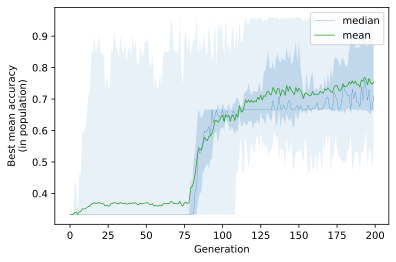

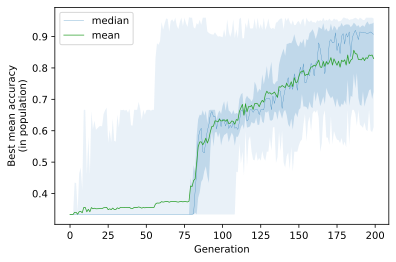

In [11]:
for data in arrays:

    quantiles = np.quantile(data, (0, 0.25, 0.5, 0.75, 1), axis=0)
    mean = np.mean(data, axis=0)

    plt.plot(gen, quantiles[2], '-', label='median', linewidth=.25, color='tab:blue')
    plt.plot(gen, mean, '-', label='mean', linewidth=.75, color='tab:green')
    plt.legend()

    plt.fill_between(gen, quantiles[1], quantiles[3], alpha=0.2, fc='tab:blue')
    plt.fill_between(gen, quantiles[0], quantiles[4], alpha=0.1, fc='tab:blue')

    plt.ylabel("Best mean accuracy\n(in population)")
    plt.xlabel("Generation")
    plt.show()